<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/S_10_LRFinder_Misclassified_Cifar10/EVA4_S12_TinyImagenet_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google drive

In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


import sys,os
from pathlib import Path


homepath = Path('/content/drive/My Drive/pytorch_Framework_suman/')
sys.path.append(str(homepath))

sys.path.append(os.path.join(homepath,'lib'))
print(sys.path)

!ls

Mounted at /content/drive
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/pytorch_Framework_suman', '/content/drive/My Drive/pytorch_Framework_suman/lib']
drive  sample_data  tiny-imagenet-200


# Initialize device

In [2]:
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print(torch.cuda.is_available())

batch_size=1024

cuda
True


# Load Tiny-Imagenet-64 Dataset and Split the dataset (train and validation) into 70% + 30%

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [0]:
from utils.splitDs import *
from lib.dataloader_s12_10 import *

In [5]:
train_dl, test_dl, train_ds, test_ds = load_data()

Images already downloaded...
/content/drive/My Drive/pytorch_Framework_suman/data/tinyImagenet/tiny-imagenet-200.zip
Extracting all the files now...
Done!
test_set dir len is : 281
train_set dir len is : 501


In [6]:
print('####Train Dataset is : \n\t\n{}\n\n'.format(train_ds))
print('####Validation Dataset is : \n\t\n{}\n\n'.format(test_ds))

print('####Train DL is : \n\t\n{}\n\n'.format(train_dl))
print('####Test DL is : \n\t\n{}\n\n'.format(test_dl))

####Train Dataset is : 
	
Dataset ImageFolder
    Number of datapoints: 100059
    Root location: train_set
    StandardTransform
Transform: <lib.dataloader_s12_10.album_compose_train object at 0x7f8693545fd0>


####Validation Dataset is : 
	
Dataset ImageFolder
    Number of datapoints: 56059
    Root location: test_set
    StandardTransform
Transform: <lib.dataloader_s12_10.album_compose_test object at 0x7f861473c5c0>


####Train DL is : 
	


####Test DL is : 
	




# Print few images from the train dataset

In [0]:
from matplotlib import pyplot as plt
def show_imgs(img,label):
    print('Image label is : {}'.format(train_ds.classes[label]))
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image label is : n01443537


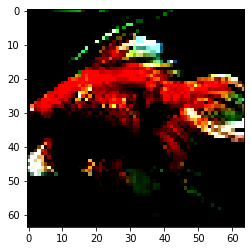

In [8]:
show_imgs(*test_ds[8])

# Print few images from the train dataloader and test data loader

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl,numOfImagesToDisplay=10,imgsPerRow=5):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(26, 26))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:numOfImagesToDisplay], imgsPerRow).permute(1, 2, 0))
        break

Print few images from Train DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


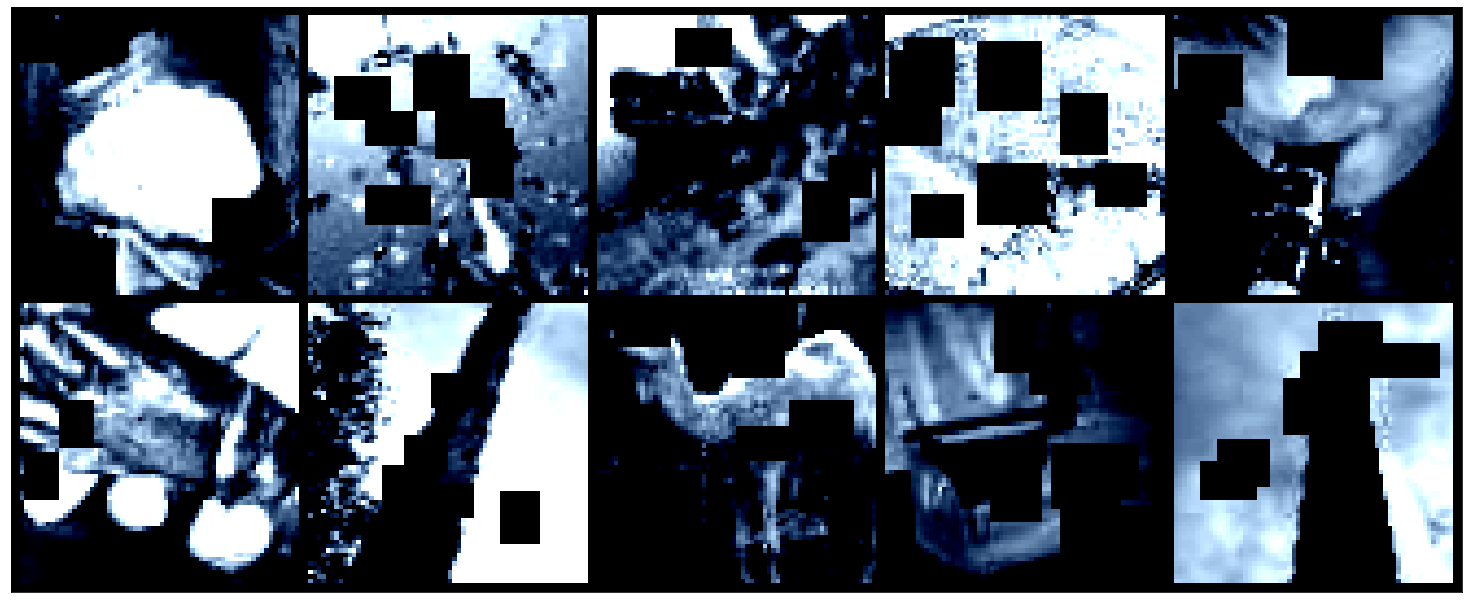

In [11]:
show_batch(train_dl)

print few Images from Test Data Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


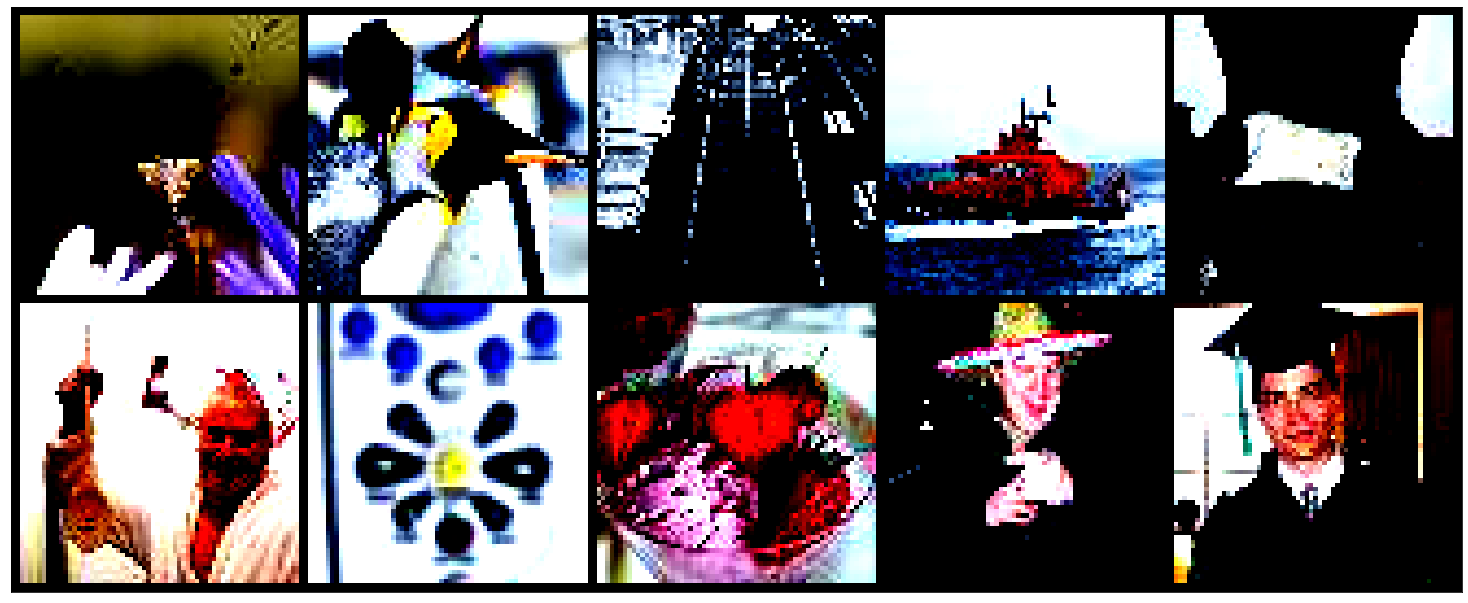

In [12]:
show_batch(test_dl)

# Test the model what we have written

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [14]:
import torchvision.models as models

model = models.resnet18()

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(device)

summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [15]:
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda()
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([1024, 3, 64, 64])
out.shape: torch.Size([1024, 200])


# Implementation of One cycle policy

In [0]:
#!pip install torch-lr-finder -v --global-option="amp"

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


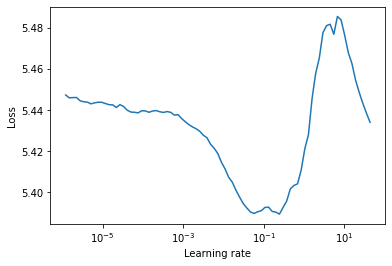

In [17]:
# LR range test
from lib.torch_lrfinder import *
from lib.torch_lrfinder import LRFinder
#from torch_lr_finder import LRFinder
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), 
                      lr=1e-7, 
                      momentum=0.9, 
                      weight_decay=1e-4)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader=train_dl,
                     #val_loader=test_dl, 
                     start_lr=1e-7,
                     end_lr=100, 
                     num_iter=100, 
                     step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [18]:
print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print('so corresponding LR value at that index is--> LRmax : {}'.format(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]))
lrmax = lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]
lrmax = float('{:4f}'.format(lrmax))
print(lrmax)

Min loss value is : 5.389428508934347 
Min LR value is   : 0.0000001514
Min loss observed at index : 69
so corresponding LR value at that index is--> LRmax : 0.24547089156850285
0.245471


In [0]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9,
                      weight_decay=1e-4)

scheduler = OneCycleLR(optimizer, 
                       max_lr = lrmax, 
                       total_steps=None,
                       pct_start=0.4, 
                       div_factor=10.0,
                       final_div_factor=100,

                       anneal_strategy='linear', 
                       epochs= 50, 
                       steps_per_epoch=1, 
                       
                       cycle_momentum=False, 
                       base_momentum=0.85, 
                       max_momentum=0.95,

)

In [0]:
trainaccuracies = []
trainlosses = []
vallosses = []
valaccuracies = []
misclassifieditems = []
lr_values = []

In [21]:
from lib import trainTestMethods
for epoch in range(1,2):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, 
                                     trainloader=train_dl, 
                                     device='cuda', 
                                     optimizer=optimizer, 
                                     criterion=criterion, 
                                     trainaccuracies=trainaccuracies, 
                                     trainlosses=trainlosses, 
                                     epoch=epoch)
    
    testloss = trainTestMethods.testWithAccPlt(network=model, 
                                               testloader=test_dl, 
                                               device='cuda', 
                                               criterion=criterion, 
                                               valaccuracies=valaccuracies, 
                                               vallosses=vallosses, 
                                               epoch=epoch)
    scheduler.step()


EPOCH: 1 LR: 0.0245471

Epoch: 1
 [================================================================>]  Step: 368ms | Tot: 59s100ms | Train >> Loss: 5.246 | Acc: 1.257% (1258/100059) 98/98 
 [===============================================================>.]  Step: 84ms | Tot: 19s485ms | Test >> Loss: 5.007 | Acc: 2.827% (1585/56059) 55/55 
0.004912193737725138


In [22]:
from lib import trainTestMethods
for epoch in range(2,51):
    print("\nEPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.trainWithAccPlt(network=model, 
                                     trainloader=train_dl, 
                                     device='cuda', 
                                     optimizer=optimizer, 
                                     criterion=criterion, 
                                     trainaccuracies=trainaccuracies, 
                                     trainlosses=trainlosses, 
                                     epoch=epoch)
    
    testloss = trainTestMethods.testWithAccPlt(network=model, 
                                               testloader=test_dl, 
                                               device='cuda', 
                                               criterion=criterion, 
                                               valaccuracies=valaccuracies, 
                                               vallosses=vallosses, 
                                               epoch=epoch)
    scheduler.step()


EPOCH: 2 LR: 0.036174673684210526

Epoch: 2
 [================================================================>]  Step: 377ms | Tot: 59s493ms | Train >> Loss: 4.931 | Acc: 3.634% (3636/100059) 98/98 
 [===============================================================>.]  Step: 87ms | Tot: 18s615ms | Test >> Loss: 4.806 | Acc: 5.626% (3154/56059) 55/55 
0.004715363126486754

EPOCH: 3 LR: 0.04780224736842105

Epoch: 3
 [================================================================>]  Step: 375ms | Tot: 59s739ms | Train >> Loss: 4.627 | Acc: 6.529% (6533/100059) 98/98 
 [===============================================================>.]  Step: 84ms | Tot: 18s826ms | Test >> Loss: 4.248 | Acc: 10.551% (5915/56059) 55/55 
0.00416756710597622

EPOCH: 4 LR: 0.05942982105263157

Epoch: 4
 [================================================================>]  Step: 375ms | Tot: 59s314ms | Train >> Loss: 4.389 | Acc: 9.265% (9270/100059) 98/98 
 [=================================================

# Plot Metrics - Accuracy and Loss

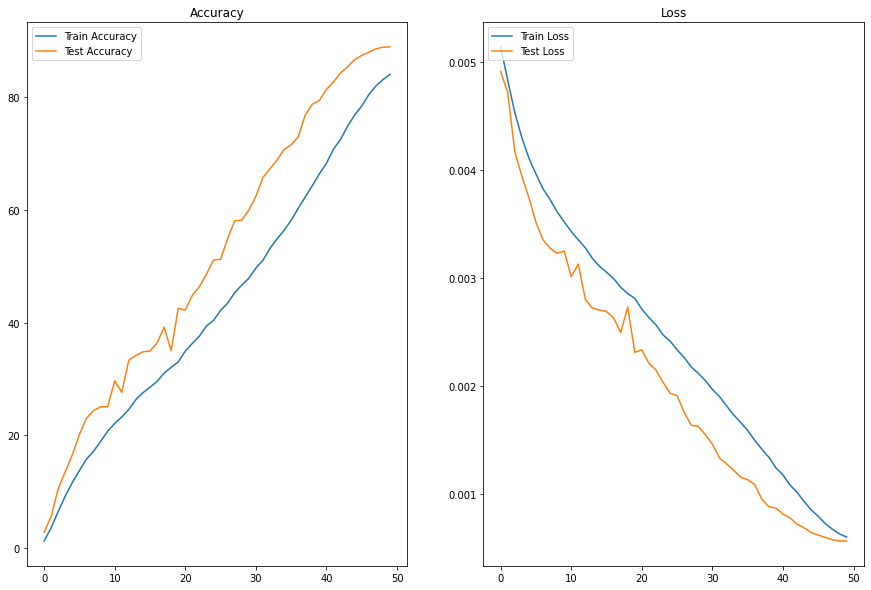

Max. Train Accuracy outoff 50-epochs is : 84.01942853716308 at 50-Epoach
Max. Test Accuracy  outoff 50-epochs is : 88.88135714158298 at 50-Epoach


Min. Train Loss outoff 50-epochs is : 0.000603 at 50-Epoach
Min. Test Loss  outoff 50-epochs is : 0.000566 at 50-Epoach


Target-50.0% achieved at 32th epoach,Train accuracy is : 51.03988646698448
Target-50.0% achieved at 25th epoach,Test accuracy is : 51.087247364383956


In [23]:
trainTestMethods.plotmetrics(50,
                             trainaccuracies=trainaccuracies, 
                             testaccuracies=valaccuracies, 
                             trainlosses=trainlosses, 
                             testlosses=vallosses, 
                             savefilename="metrics")

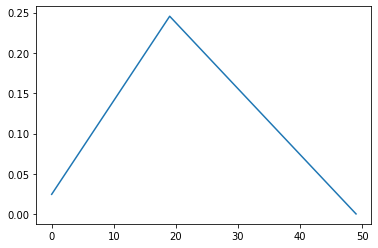

In [24]:
plt.plot(lr_values)

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  